In [10]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from net import NormalNetwork, PCANetwork, train_network, test_network
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Train with MNIST dataset

In [2]:
model = NormalNetwork(unpack_data=True)

In [3]:
train_network(model)

Training epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:01<00:00, 1089.61it/s]


#### Test with MNIST dataset

In [4]:
res = test_network(model)
print(res)

Testing network: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1348.99it/s]

{'accuracy': 0.9791, 'loss': 0.06446099373287972, 'confusion matrix': array([[ 968,    0,    1,    1,    1,    2,    3,    1,    2,    1],
       [   0, 1128,    2,    1,    0,    1,    2,    0,    1,    0],
       [   3,    3, 1011,    2,    2,    0,    3,    3,    5,    0],
       [   0,    0,    7,  990,    0,    4,    0,    2,    3,    4],
       [   0,    0,    3,    0,  969,    0,    2,    1,    0,    7],
       [   2,    0,    0,    6,    1,  875,    2,    0,    3,    3],
       [   5,    3,    1,    1,    4,    6,  937,    0,    1,    0],
       [   2,    5,    7,    1,    4,    0,    0,  996,    2,   11],
       [   5,    0,    3,    7,    4,    7,    3,    3,  937,    5],
       [   2,    2,    0,    5,   11,    3,    1,    4,    1,  980]])}


#### Plot confusion matrix

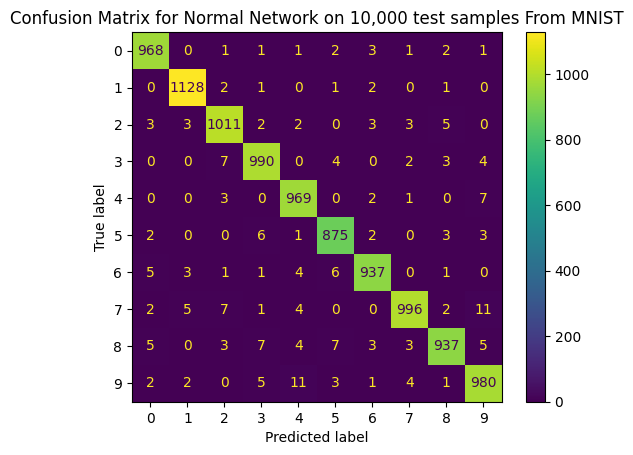

In [5]:
disp = ConfusionMatrixDisplay(confusion_matrix= res["confusion matrix"])
disp.plot()
plt.title("Confusion Matrix for Normal Network on 10,000 test samples From MNIST")
plt.show()

#### Train with PCA data

In [5]:
model = PCANetwork(0.75, unpack_data=True)

In [6]:
model

PCANetwork(
  (forward_prob): Sequential(
    (0): Linear(in_features=120, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (loss_func): CrossEntropyLoss()
)

In [7]:
train_network(model)

Training epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:00<00:00, 2210.68it/s]


In [8]:
res = test_network(model)
print(res)

Testing network: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 2715.57it/s]

{'accuracy': 0.9632, 'loss': 0.13335920090135484, 'confusion matrix': array([[ 969,    0,    0,    1,    1,    2,    3,    1,    1,    2],
       [   0, 1122,    3,    3,    0,    0,    1,    1,    4,    1],
       [   7,    1,  989,    7,    4,    2,    6,    7,    9,    0],
       [   0,    1,    9,  971,    0,    8,    0,    9,    7,    5],
       [   2,    0,    6,    0,  949,    0,    6,    7,    0,   12],
       [   4,    0,    0,    9,    2,  863,    3,    2,    6,    3],
       [   9,    3,    1,    1,    8,   13,  918,    0,    5,    0],
       [   2,    6,   17,    4,    2,    0,    0,  984,    1,   12],
       [   6,    3,    5,   16,    7,    7,    3,    8,  914,    5],
       [   4,    5,    1,    7,   17,    7,    0,    8,    7,  953]])}


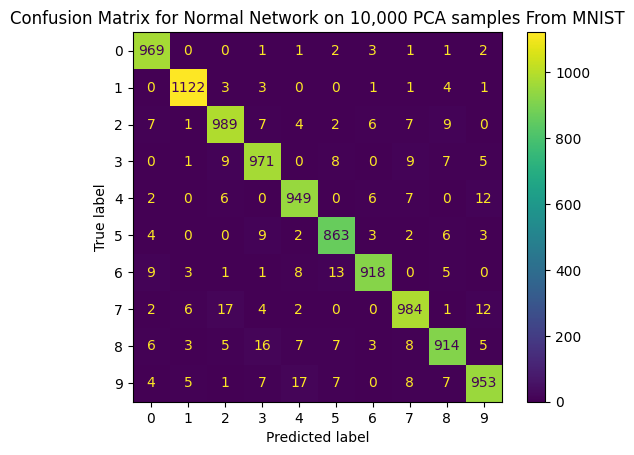

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=res["confusion matrix"])
disp.plot()
plt.title("Confusion Matrix for Normal Network on 10,000 PCA samples From MNIST")
plt.show()

In [2]:
from graph import draw_metric_graph, draw_time_graph

Initializing networks...


Testing network: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 1596.35it/s]


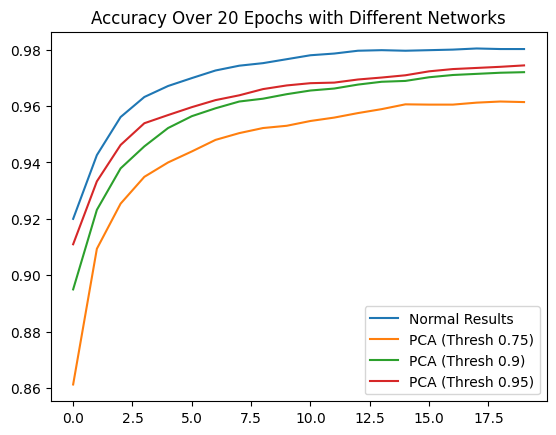

In [3]:
draw_metric_graph(pca_thresh=[0.75, 0.90, 0.95], epochs=20)

Training epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:00<00:00, 2194.12it/s]


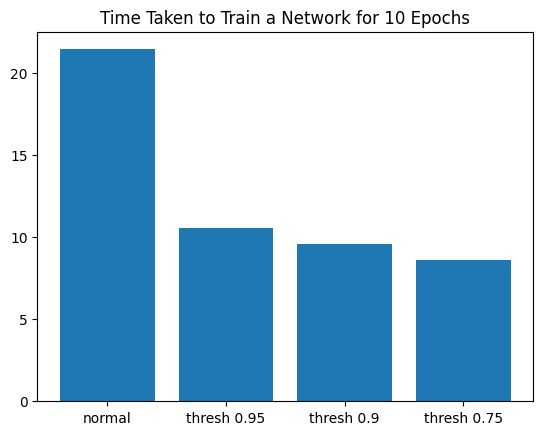

In [4]:
draw_time_graph(pca_thresh=[0.95, 0.90, 0.75], epochs=10)